### 1 神经网络

该任务是处理手写数字数据集，使用反向传播的前馈神经网络，自动学习神经网络的参数。

### 1.1 数据可视化

5000张20*20像素的手写数字数据集，以及对应的数字（1-9，0对应10）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = loadmat("./datasets/ex4data1.mat")
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

In [4]:
weight = loadmat("./datasets/ex4weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

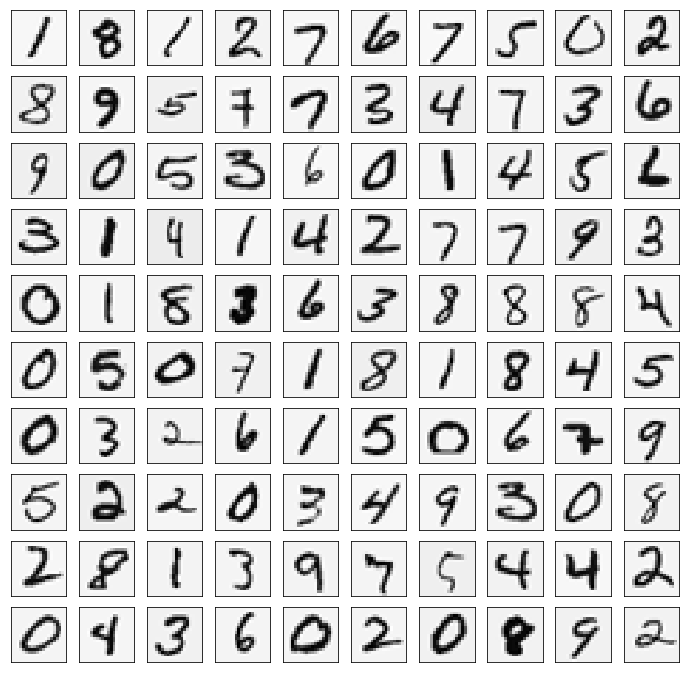

In [7]:
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx,:]

fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12,12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T, cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

### 1.2 前向传播和代价函数

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
# 前向传播函数
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [10]:
def cost(theta1, theta2, input_size, hidden_size, num_labels, X, y, lr):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    return J

In [11]:
# 对y标签进行编码
# y (5000,1)-->(5000,10)

encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [12]:
y[1], y_onehot[1,:] # y0是数字0

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [13]:
# 初始化设置
input_size = 400
hidden_size = 25
num_labels = 10
lr = 1

In [15]:
cost(theta1, theta2, input_size, hidden_size, num_labels, X, y_onehot, lr)

0.2876291651613187

### 1.3 正则化代价函数

In [16]:
def costReg(theta1, theta2, input_size, hidden_size, num_labels, X, y, lr):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    J += (float(lr) / (2 * m)) * (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    
    return J  

In [17]:
costReg(theta1, theta2, input_size, hidden_size, num_labels, X, y_onehot, lr)

0.3837698590909234

### 2 反向传播

实现反向传播的算法，来计算神经网络代价函数的梯度。获得了梯度的数据，使用工具库来计算代价函数的最小值。

### 2.1 sigmoid梯度计算

In [18]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [19]:
sigmoid_gradient(0)

0.25

### 2.2 随机初始

In [20]:
# np.random.random(size) 返回size大小的0-1随机浮点数
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.24

### 2.3 反向传播

In [21]:
def backprop(params, input_size, hidden_size, num_labels, X, y, lr):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # 前向传播计算各个值
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # reshape the parameter array into parameter matrices for each layer
    #（25，401）
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    #（10, 26）
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # 初始化
    J = 0
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)
    
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # 执行反向传播
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    return J, delta1, delta2

### 2.4 正则化神经网络

In [22]:
def backpropReg(params, input_size, hidden_size, num_labels, X, y, lr):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # 加入正则项
    J += (float(lr) / (2 * m)) * (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    
    # 执行反向传播
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # 加入正则项
    delta1[:, 1:] = delta1[:, 1:] + (theta1[:, 1:] * lr) / m
    delta2[:, 1:] = delta2[:, 1:] + (theta2[:, 1:] * lr) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

### 2.5 使用工具库计算参数最优解

In [23]:
from scipy.optimize import minimize

fmin = minimize(fun=backpropReg, x0=(params), args=(input_size, hidden_size, num_labels, X, y_onehot, lr), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.33048486554434725
     jac: array([-4.38937544e-05, -3.03662717e-07,  7.43778187e-07, ...,
        6.50102394e-05,  6.82809182e-05, -2.00304489e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 251
     nit: 22
  status: 3
 success: False
       x: array([-1.05018747, -0.00151831,  0.00371889, ..., -1.13754685,
        0.58840581, -1.33891527])

In [24]:
X = np.matrix(X)
thetafinal1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
thetafinal2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

In [25]:
# 计算使用优化后的θ得出的预测
a1, z2, a2, z3, h = forward_propagate(X, thetafinal1, thetafinal2 )
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [26]:
# 预测值与实际值比较
from sklearn.metrics import classification_report#这个包是评价报告
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       0.99      0.99      0.99       500
           3       1.00      0.99      0.99       500
           4       1.00      0.99      0.99       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      0.99      0.99       500
           8       0.99      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       0.99      1.00      1.00       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



### 3 可视化隐藏层

In [27]:
hidden_layer = thetafinal1[:, 1:] 
hidden_layer.shape

(25, 400)

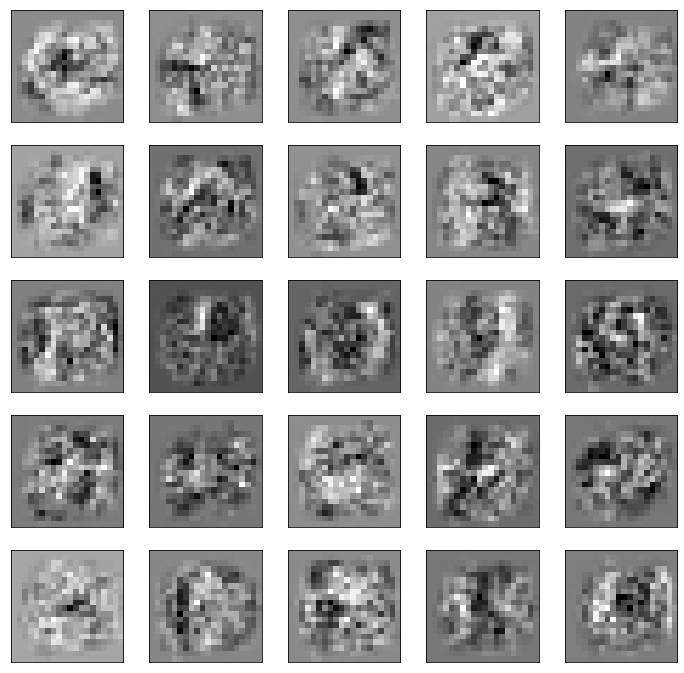

In [28]:
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(hidden_layer[5 * r + c].reshape((20, 20))),cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 